## Tabular Playground Series July 21
**Objective** : Predicting the pollution level(benzene, nitrous oxide and carbon monoxide)

**Dependent Variables** : target_carbon_monoxide, target_benzene, target_nitrogen_oxides

**Independent Variables** : date_time, deg_C, relative_humidity, absolute_humidity,sensor_1, sensor_2, sensor_3, sensor_4, sensor_5

In [27]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import catboost as cbt

import random, os
import math

import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import pi

from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import cross_val_score
from pylab import rcParams
rcParams['figure.figsize']=15,4

import warnings
warnings.simplefilter('ignore')

RANDOM_SEED = 42

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(RANDOM_SEED)

In [28]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sample=pd.read_csv('sample_submission.csv')

train['date_time']=pd.to_datetime(train['date_time'])
test['date_time']=pd.to_datetime(test['date_time'])

train=train.set_index('date_time')
test=test.set_index('date_time')

targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
train[targets] = np.log1p(train[targets])

df=pd.concat([train,test.iloc[1:]],axis=0,sort=False)

In [29]:
df['month']=df.index.month
df['weekday']=df.index.dayofweek
df['year']=df.index.year
df['hour']=df.index.hour

Text(0.5, 1.0, 'absolute_humidity')

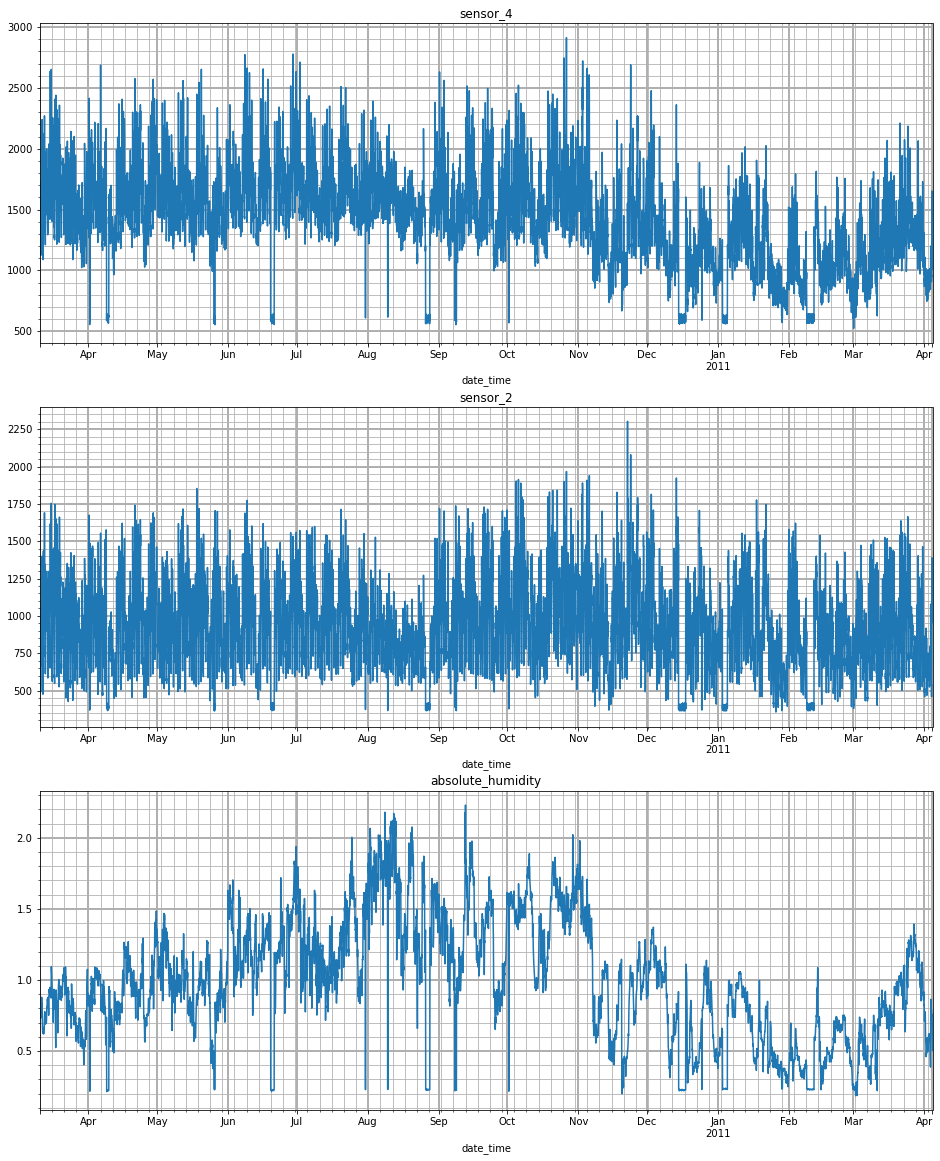

In [30]:
plt.figure(figsize=(16,20))

plt.subplot(3,1,1)
df['sensor_4'].asfreq('H').plot()
plt.minorticks_on()
plt.grid(which='minor')
plt.grid(which='major',linewidth=2)
plt.title('sensor_4')

plt.subplot(3,1,2)
df['sensor_2'].asfreq('H').plot()
plt.minorticks_on()
plt.grid(which='minor')
plt.grid(which='major',linewidth=2)
plt.title('sensor_2')

plt.subplot(3,1,3)
df['absolute_humidity'].asfreq('H').plot()
plt.minorticks_on()
plt.grid(which='minor')
plt.grid(which='major',linewidth=2)
plt.title('absolute_humidity')

- **Abnormalities can be seen in the above 3 features as their are some sudden fall and rise of readings at some points which are almost same in value**

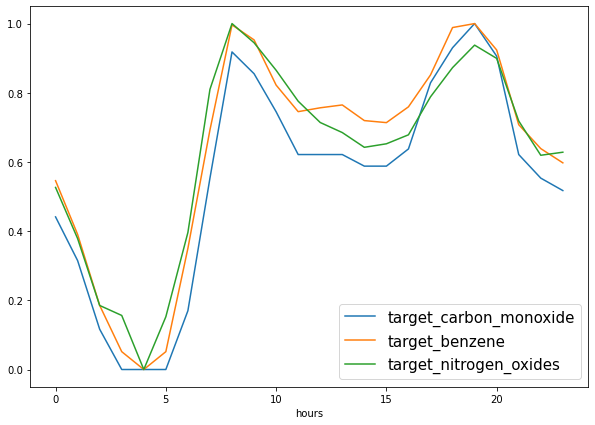

In [31]:
scale=MinMaxScaler()

plt.figure(figsize=(10,7))
for i in range(3):
    a=df.groupby(['hour']).median()[targets[i]]
    plt.plot(a.index,scale.fit_transform(a.values.reshape(-1,1)),label=targets[i])
plt.legend(loc='lower right',prop={'size':15})
plt.xlabel('hours')
plt.show()

- **It is evident from the above plot that pollution levl is high during working hours, specially during office hours**

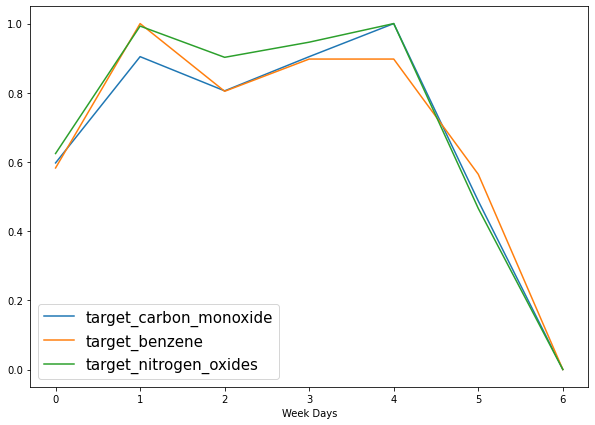

In [32]:
scale=MinMaxScaler()

plt.figure(figsize=(10,7))
for i in range(3):
    a=df.groupby(['weekday']).median()[targets[i]]
    plt.plot(a.index,scale.fit_transform(a.values.reshape(-1,1)),label=targets[i])
plt.legend(loc='lower left',prop={'size':15})
plt.xlabel('Week Days')
plt.show()

- **It is evident from the above plot that pollution level is high from monday(0) to friday(4) and lower in weekends**

In [33]:
df['working_hour']=df['hour'].isin(np.arange(8,21,1)).astype('i')
df['is_weekend']=(df['weekday']>=5).astype('i')
df['sat']=(df.weekday==5).astype('i')
df['saturation_point']=df['absolute_humidity']*100/df['relative_humidity']
df['is_odd']=((df['sensor_4']<646)&(df['absolute_humidity']<0.238)&(df['sensor_2']<426)).astype('i')

q=np.arange(0,len(df),1)

df['sin']=np.sin(2*pi*q/24)
df['sin1']=np.sin(2*pi*q/(24*7))
df['sin2']=np.sin(2*pi*q/(24*365))

### Seasonal decomposition

In [34]:
for i in train.drop(targets,axis=1).columns:
        add=seasonal_decompose(df[i], model='additive', period = 24,two_sided=False)
        add1=seasonal_decompose(df[i], model='additive', period = 24*7,two_sided=False)
        data=pd.concat([add.resid,add.seasonal,add.trend],axis=1).fillna(0)
        data.columns=[f'{i}_resid',f'{i}_seas',f'{i}_trend']
        data1=pd.concat([add1.resid,add1.seasonal,add1.trend],axis=1).fillna(0)
        data1.columns=[f'{i}_resid1',f'{i}_seas1',f'{i}_trend1']
        df=pd.concat([df,data,data1],axis=1)
#df.dropna(inplace=True,subset=df.columns.drop(targets))

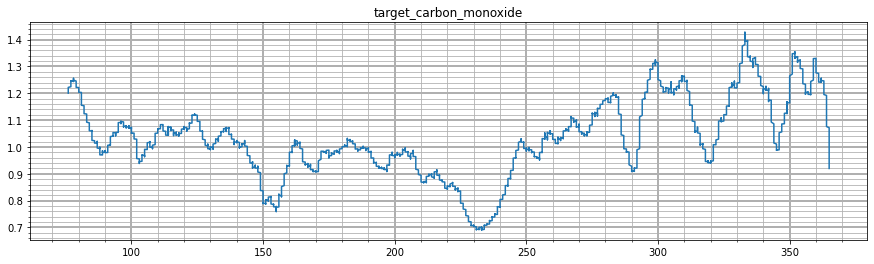

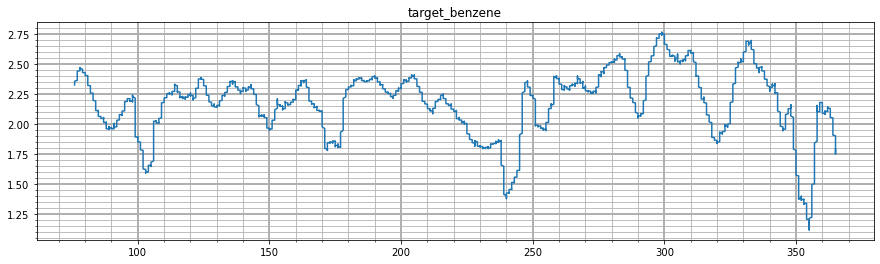

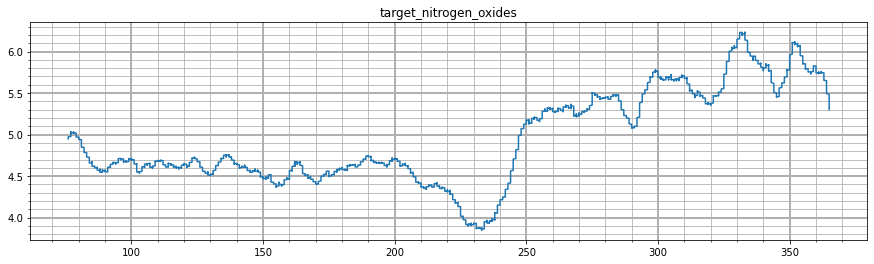

In [35]:
for i in targets:
    ad=seasonal_decompose(train[i], model='additive', period = 24,two_sided=False)
    df=pd.concat([df,ad.seasonal],axis=1)
    dic=dict(df.groupby([df.hour]).mean()['seasonal'])
    df[f'decompose_{i}']=df.hour.map(dic)
    df.drop('seasonal',axis=1,inplace=True)
    
    ad=seasonal_decompose(train[i], model='additive', period = 24*7,two_sided=False)
    df=pd.concat([df,ad.seasonal],axis=1)
    plt.plot(train.index.dayofyear[:-1],ad.trend[:-1])
    plt.minorticks_on()
    plt.grid(which='minor')
    plt.grid(which='major',linewidth=2)
    plt.title(i)
    plt.show()
    
    df[f'decompose1_{i}']=df[['weekday','hour']].apply(lambda x:df.groupby([df.weekday,df.hour]).mean()['seasonal'][x[0]][x[1]],axis=1)
    df.drop('seasonal',axis=1,inplace=True)
df.drop('hour',axis=1,inplace=True)

- **From the above plots, some new features can be added as trend is different for different range of days**

In [40]:
df['range1']=((df.index.dayofyear>=90)&(df.index.dayofyear<200)).astype('i')
df['range2']=((df.index.dayofyear>=200)&(df.index.dayofyear<250)).astype('i')
df['range3']=((df.index.dayofyear>=250)&(df.index.dayofyear<290)).astype('i')
df['range4']=((df.index.dayofyear>=290)&(df.index.dayofyear<320)).astype('i')
df['range5']=((df.index.dayofyear>=320)&(df.index.dayofyear<345)).astype('i')
df['range6']=((df.index.dayofyear>=345)&(df.index.dayofyear<365)).astype('i')

## Data Split

In [98]:
df_train= df.loc[train.index]
df_test=df.loc[test.index]

## Model Learning

In [99]:
rand_states = [2021, 1998, 42, 123]

### Carbon Monoxide

In [102]:
print(f"\nTraining regressors for carbon monoxide")

target = 'target_carbon_monoxide'

targets.remove(target)
drop=[i for i in df_train.columns if ((targets[0] in i)|(targets[1] in i))]
targets.append(target)

train=df_train.drop(drop,axis=1)
test=df_test.drop(drop,axis=1)
    
yhat = np.zeros((sample.shape[0],1))
    
for rand in rand_states:
    print(f"\nRandom state {rand} ")
    seed_everything(rand)
    
    m_lgb = lgb.LGBMRegressor(seed = rand)
    m_ctb = cbt.CatBoostRegressor(random_seed = rand, verbose=False)

    stack = StackingCVRegressor(regressors=(m_lgb, m_ctb), meta_regressor = BayesianRidge(normalize = True))

    regressors = ['LightGBM', 'CatBoost', 'StackingCVRegressor']

    for clf, label in zip([m_lgb, m_ctb, stack], regressors):
        
        scores = cross_val_score(clf, train.drop(target, axis = 1), train[target], cv = 3, scoring='neg_mean_squared_error')
        print("  - Neg. MSE Score: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

    stack.fit(train.drop(target, axis = 1), train[target])
        
    yhat += np.expm1(stack.predict(test.drop(target, axis = 1))).reshape(-1, 1)
        
sample[target] = yhat / len(rand_states)


Training regressors for carbon monoxide

Random state 2021 
  - Neg. MSE Score: -0.0196 (+/- 0.0108) [LightGBM]
  - Neg. MSE Score: -0.0183 (+/- 0.0102) [CatBoost]
  - Neg. MSE Score: -0.0181 (+/- 0.0102) [StackingCVRegressor]

Random state 1998 
  - Neg. MSE Score: -0.0196 (+/- 0.0108) [LightGBM]
  - Neg. MSE Score: -0.0188 (+/- 0.0102) [CatBoost]
  - Neg. MSE Score: -0.0185 (+/- 0.0102) [StackingCVRegressor]

Random state 42 
  - Neg. MSE Score: -0.0196 (+/- 0.0108) [LightGBM]
  - Neg. MSE Score: -0.0182 (+/- 0.0099) [CatBoost]
  - Neg. MSE Score: -0.0179 (+/- 0.0101) [StackingCVRegressor]

Random state 123 
  - Neg. MSE Score: -0.0196 (+/- 0.0108) [LightGBM]
  - Neg. MSE Score: -0.0181 (+/- 0.0100) [CatBoost]
  - Neg. MSE Score: -0.0179 (+/- 0.0101) [StackingCVRegressor]


## Benzene

In [103]:
print(f"\nTraining regressors for Benzene")

target = 'target_benzene'

targets.remove(target)
drop=[i for i in df_train.columns if ((targets[0] in i)|(targets[1] in i))]
targets.append(target)

train=df_train.drop(drop,axis=1)
test=df_test.drop(drop,axis=1)
    
yhat = np.zeros((sample.shape[0],1))
    
for rand in rand_states:
    print(f"\nRandom state {rand} ")
    seed_everything(rand)
    
    m_lgb = lgb.LGBMRegressor(seed = rand)
    m_ctb = cbt.CatBoostRegressor(random_seed = rand, verbose=False)

    stack = StackingCVRegressor(regressors=(m_lgb, m_ctb), meta_regressor = BayesianRidge(normalize = True))

    regressors = ['LightGBM', 'CatBoost', 'StackingCVRegressor']

    for clf, label in zip([m_lgb, m_ctb, stack], regressors):
        
        scores = cross_val_score(clf, train.drop(target, axis = 1), train[target], cv = 3, scoring='neg_mean_squared_error')
        print("  - Neg. MSE Score: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

    stack.fit(train.drop(target, axis = 1), train[target])
        
    yhat += np.expm1(stack.predict(test.drop(target, axis = 1))).reshape(-1, 1)
        
sample[target] = yhat / len(rand_states)


Training regressors for carbon monoxide

Random state 2021 
  - Neg. MSE Score: -0.0089 (+/- 0.0013) [LightGBM]
  - Neg. MSE Score: -0.0103 (+/- 0.0028) [CatBoost]
  - Neg. MSE Score: -0.0092 (+/- 0.0020) [StackingCVRegressor]

Random state 1998 
  - Neg. MSE Score: -0.0089 (+/- 0.0013) [LightGBM]
  - Neg. MSE Score: -0.0106 (+/- 0.0028) [CatBoost]
  - Neg. MSE Score: -0.0093 (+/- 0.0021) [StackingCVRegressor]

Random state 42 
  - Neg. MSE Score: -0.0089 (+/- 0.0013) [LightGBM]
  - Neg. MSE Score: -0.0104 (+/- 0.0031) [CatBoost]
  - Neg. MSE Score: -0.0092 (+/- 0.0021) [StackingCVRegressor]

Random state 123 
  - Neg. MSE Score: -0.0089 (+/- 0.0013) [LightGBM]
  - Neg. MSE Score: -0.0110 (+/- 0.0033) [CatBoost]
  - Neg. MSE Score: -0.0096 (+/- 0.0024) [StackingCVRegressor]


## Nitrogen Oxide

In [139]:
print(f"\nTraining regressors for Nitrogen Oxide")

target = 'target_nitrogen_oxides'

targets.remove(target)
drop=[i for i in df_train.columns if ((targets[0] in i)|(targets[1] in i))]
targets.append(target)

train=df_train.drop(drop,axis=1)[df_train.index.month>8]
test=df_test.drop(drop,axis=1)
    
yhat = np.zeros((sample.shape[0],1))
    
for rand in rand_states:
    print(f"\nRandom state {rand} ")
    seed_everything(rand)
    
    m_lgb = lgb.LGBMRegressor(seed = rand)
    m_ctb = cbt.CatBoostRegressor(random_seed = rand, verbose=False)

    stack = StackingCVRegressor(regressors=(m_lgb, m_ctb), meta_regressor = BayesianRidge(normalize = True))

    regressors = ['LightGBM', 'CatBoost', 'StackingCVRegressor']

    for clf, label in zip([m_lgb, m_ctb, stack], regressors):
        
        scores = cross_val_score(clf, train.drop(target, axis = 1), train[target], cv = 3, scoring='neg_mean_squared_error')
        print("  - Neg. MSE Score: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

    stack.fit(train.drop(target, axis = 1), train[target])
        
    yhat += np.expm1(stack.predict(test.drop(target, axis = 1))).reshape(-1, 1)
        
sample[target] = yhat / len(rand_states)


Training regressors for Nitrogen Oxide

Random state 2021 
  - Neg. MSE Score: -0.1128 (+/- 0.0400) [LightGBM]
  - Neg. MSE Score: -0.1203 (+/- 0.0502) [CatBoost]
  - Neg. MSE Score: -0.1155 (+/- 0.0477) [StackingCVRegressor]

Random state 1998 
  - Neg. MSE Score: -0.1128 (+/- 0.0400) [LightGBM]
  - Neg. MSE Score: -0.1163 (+/- 0.0493) [CatBoost]
  - Neg. MSE Score: -0.1114 (+/- 0.0458) [StackingCVRegressor]

Random state 42 
  - Neg. MSE Score: -0.1128 (+/- 0.0400) [LightGBM]
  - Neg. MSE Score: -0.1150 (+/- 0.0477) [CatBoost]
  - Neg. MSE Score: -0.1115 (+/- 0.0459) [StackingCVRegressor]

Random state 123 
  - Neg. MSE Score: -0.1128 (+/- 0.0400) [LightGBM]
  - Neg. MSE Score: -0.1109 (+/- 0.0462) [CatBoost]
  - Neg. MSE Score: -0.1081 (+/- 0.0439) [StackingCVRegressor]


In [140]:
sample.iloc[0,1:]=np.expm1(df_train[targets].iloc[-1])

In [141]:
sample.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.400000,4.100000,186.500000
1,2011-01-01 01:00:00,2.110891,7.374376,360.745143
2,2011-01-01 02:00:00,1.776502,7.125898,305.511248
3,2011-01-01 03:00:00,1.878108,7.958346,342.101722
4,2011-01-01 04:00:00,1.268111,6.133655,238.007319


In [142]:
sample.to_csv('submission.csv',index=False)